### I. Install and import packages

In [2]:
!pip install -q cohere pandas matplotlib seaborn

import os
import pandas as pd
import cohere
import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import time
from tqdm import tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 52.1 MB/s eta 0:00:00


### II. Set up the Cohere API key

In [ ]:
cohere_api_key = "XXXXXX" # Input your Cohere API KEY

In [4]:
import getpass

COHERE_API_KEY = getpass.getpass(cohere_api_key)
co = cohere.Client(COHERE_API_KEY)

HEl4nUtEuACx9xFXtQWj1g6kN4h897EEOeM1Z2mK··········


### III. Load customer data from pre-uploaded /content/transcripts_v3

In [7]:
def load_member_conversations(path):
    conversations = []
    for file in os.listdir(path):
        if file.endswith('.txt'):
            with open(os.path.join(path, file), 'r', encoding='utf-8') as f:
                text = f.read()
                # Extract all lines spoken by the Member
                member_lines = [line.split(":", 1)[1].strip()
                                for line in text.splitlines()
                                if line.strip().lower().startswith("member:")]
                member_text = " ".join(member_lines)
                conversations.append({'filename': file, 'member_text': member_text})
    return pd.DataFrame(conversations)

df = load_member_conversations('/content/transcripts_v3')
df.head()

,filename,member_text
0,transcript_185.txt,"Hi, I'm calling to get a case pre-authorized. ..."
1,transcript_87.txt,"Hi, I'm calling about a denied claim I receive..."
2,transcript_46.txt,"Hi, I'm having some trouble registering and lo..."
3,transcript_146.txt,"Hi, I'm calling about a denied claim. My claim..."
4,transcript_38.txt,"Hi, I'm calling to get a case pre-authorized f..."


### IV. Function to classify sentiment and outcome using Cohere Chat API

In [8]:
def classify_text_with_chat(text):
    try:
        prompt = f"""
You are a helpful assistant for an insurance call center. Please analyze the following customer dialogue and determine:
1. The overall sentiment (positive, negative, or neutral)
2. The outcome of the call (issue resolved or follow-up action needed)

Customer says:
\"\"\"
{text}
\"\"\"

Respond in the following format:
Sentiment: <positive/negative/neutral>
Call Outcome: <issue resolved/follow-up action needed>
"""

        response = co.chat(
            message=prompt,
            model='command-r-plus',
            temperature=0.3
        )

        return response.text.strip()

    except Exception as e:
        return f"Error: {e}"

### V. Split into chunks of 20 entries each

In [9]:
def split_dataframe(df, chunk_size=20):
    return [df.iloc[i:i + chunk_size].copy() for i in range(0, len(df), chunk_size)]

chunks = split_dataframe(df, 20)

### VI. Process each chunk and extract sentiment & outcome

In [10]:
processed_chunks = []

for i, chunk in enumerate(chunks):
    print(f"\n🔄 Processing chunk {i+1}/{len(chunks)}")
    results = []

    for j, text in enumerate(tqdm(chunk['member_text'], desc=f"Chunk {i+1}")):
        result = classify_text_with_chat(text)
        results.append(result)
        time.sleep(1.5)  # small pause to avoid hitting rate limits

    chunk['response'] = results
    chunk['sentiment'] = chunk['response'].str.extract(r"Sentiment:\s*(\w+)", expand=False).str.lower()
    chunk['call_outcome'] = chunk['response'].str.extract(r"Call Outcome:\s*(.*)", expand=False).str.lower()
    processed_chunks.append(chunk)



🔄 Processing chunk 1/10


Chunk 1: 100%|██████████| 20/20 [00:40<00:00,  2.03s/it]



🔄 Processing chunk 2/10


Chunk 2: 100%|██████████| 20/20 [00:42<00:00,  2.10s/it]



🔄 Processing chunk 3/10


Chunk 3: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]



🔄 Processing chunk 4/10


Chunk 4: 100%|██████████| 20/20 [00:39<00:00,  1.99s/it]



🔄 Processing chunk 5/10


Chunk 5: 100%|██████████| 20/20 [03:07<00:00,  9.39s/it]



🔄 Processing chunk 6/10


Chunk 6: 100%|██████████| 20/20 [00:40<00:00,  2.05s/it]



🔄 Processing chunk 7/10


Chunk 7: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]



🔄 Processing chunk 8/10


Chunk 8: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]



🔄 Processing chunk 9/10


Chunk 9: 100%|██████████| 20/20 [00:39<00:00,  1.97s/it]



🔄 Processing chunk 10/10


Chunk 10: 100%|██████████| 20/20 [00:38<00:00,  1.95s/it]


### VII. Combine everything back into a single DataFrame

In [11]:
final_df = pd.concat(processed_chunks, ignore_index=True)
final_df.to_csv('/content/final_transcript_analysis.csv', index=False)
final_df.head()


,filename,member_text,response,sentiment,call_outcome
0,transcript_185.txt,"Hi, I'm calling to get a case pre-authorized. ...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
1,transcript_87.txt,"Hi, I'm calling about a denied claim I receive...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
2,transcript_46.txt,"Hi, I'm having some trouble registering and lo...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
3,transcript_146.txt,"Hi, I'm calling about a denied claim. My claim...",Sentiment: Positive\nCall Outcome: Issue Resolved,positive,issue resolved
4,transcript_38.txt,"Hi, I'm calling to get a case pre-authorized f...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved


### VIII. Visualise the Results

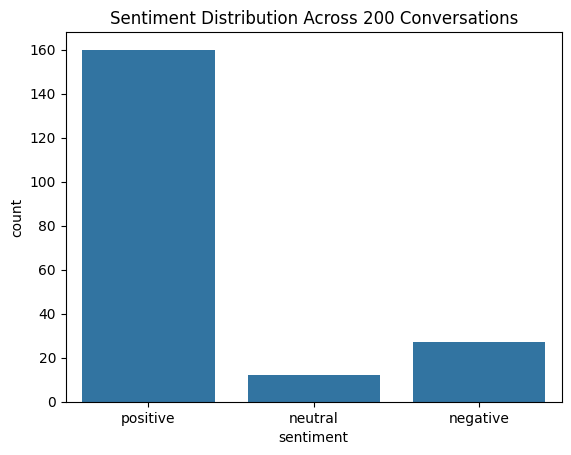

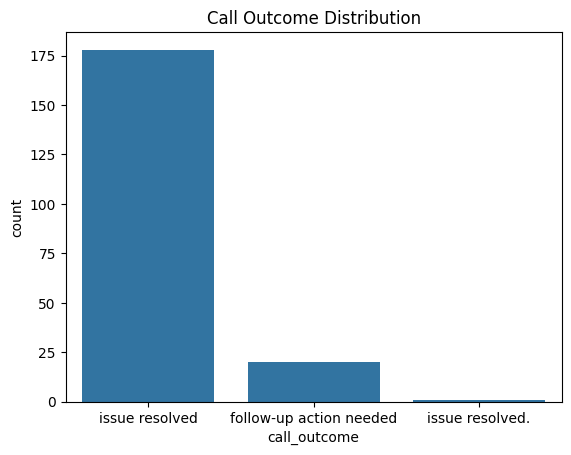

call_outcome,follow-up action needed,issue resolved,issue resolved.
sentiment,,,
negative,0.592593,0.407407,0.000000
neutral,0.250000,0.666667,0.083333
positive,0.006250,0.993750,0.000000


In [12]:
# Sentiment Distribution
sns.countplot(data=final_df, x='sentiment')
plt.title('Sentiment Distribution Across 200 Conversations')
plt.show()

# Outcome Distribution
sns.countplot(data=final_df, x='call_outcome')
plt.title('Call Outcome Distribution')
plt.show()

# Cross-tab Analysis
pd.crosstab(final_df['sentiment'], final_df['call_outcome'], normalize='index')


### IX. Save Output for GitHub or Reporting

In [13]:
# Save as CSV for GitHub or final use
final_df.to_csv('/content/analyzed_transcripts.csv', index=False)


### X. Evaluate the Model (Manually Label First 20 Transcripts)

In [15]:
final_df[:20]

,filename,member_text,response,sentiment,call_outcome
0,transcript_185.txt,"Hi, I'm calling to get a case pre-authorized. ...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
1,transcript_87.txt,"Hi, I'm calling about a denied claim I receive...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
2,transcript_46.txt,"Hi, I'm having some trouble registering and lo...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
3,transcript_146.txt,"Hi, I'm calling about a denied claim. My claim...",Sentiment: Positive\nCall Outcome: Issue Resolved,positive,issue resolved
4,transcript_38.txt,"Hi, I'm calling to get a case pre-authorized f...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
5,transcript_141.txt,"Hi, I'm calling about a denied claim I receive...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
6,transcript_188.txt,"Hi, I'm calling about my recent visit to the d...",Sentiment: Positive\nCall Outcome: Issue Resolved,positive,issue resolved
7,transcript_157.txt,"Hi, I'm calling to get a case pre-authorized. ...",Sentiment: Positive\nCall Outcome: Issue Resolved,positive,issue resolved
8,transcript_16.txt,"Hi, I'm calling about my online service accoun...",Sentiment: Positive\nCall Outcome: Issue resolved,positive,issue resolved
9,transcript_148.txt,"Hi, I'm calling about my recent doctor's visit...",Sentiment: Positive\nCall Outcome: Issue Resolved,positive,issue resolved


In [17]:
from sklearn.metrics import accuracy_score, classification_report

# Replace these with your manually labeled ground truth
y_true_sentiment = ['positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'positive',
            'neutral',
            'positive',
            'negative',
            'positive',
            'negative',
            'neutral',
            'positive',
            'positive',
            ]  # 20 values
y_pred_sentiment = final_df['sentiment'][:20]

print("Sentiment Accuracy:", accuracy_score(y_true_sentiment, y_pred_sentiment))
print("Classification Report:\n", classification_report(y_true_sentiment, y_pred_sentiment))

Sentiment Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

    negative       1.00      1.00      1.00         2
     neutral       1.00      1.00      1.00         2
    positive       1.00      1.00      1.00        16

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



### XI. Exploratory Data Analysis (EDA)

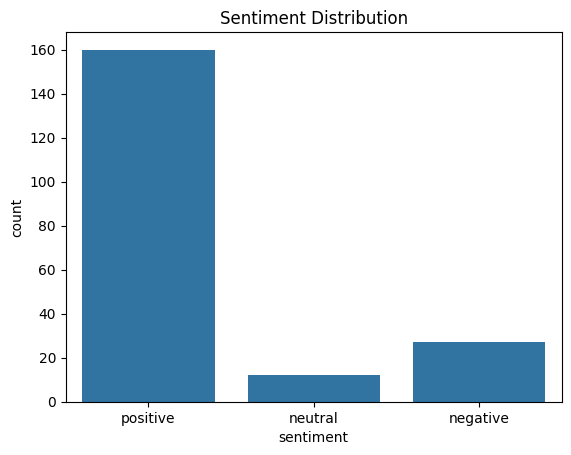

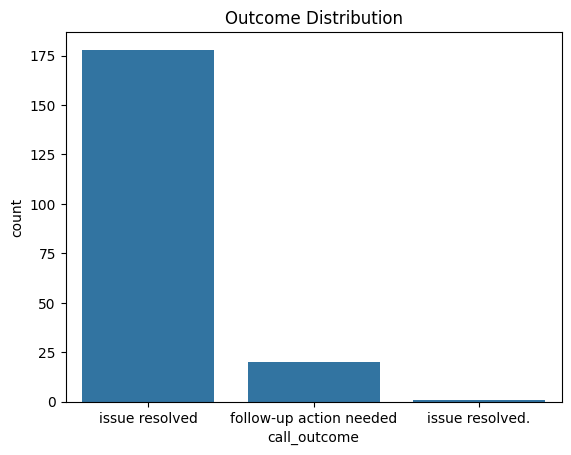

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=final_df, x='sentiment')
plt.title("Sentiment Distribution")
plt.show()

sns.countplot(data=final_df, x='call_outcome')
plt.title("Outcome Distribution")
plt.show()